# 📌 End To End Steps

1️⃣ Load & Explore Data – Import earthquake dataset, preprocess, and visualize.

2️⃣ Train-Test Split – Split time series correctly (no shuffling).

3️⃣ Analyze - plot ACF/PACF.

4️⃣ Achieve Stationarity – Apply differencing, ADF test

5️⃣ Baseline Models – Compare with historical mean & last-value models.

6️⃣ Fit AR Model – Select lag order, train AR(p)

7️⃣ Evaluate Performance – Compare with baselines using MAE

8️⃣ Forecast Future Data – Predict and visualize earthquake trends.

# 🔹 Step 1: Import Libraries & Load Data

In [36]:

# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller

# Load dataset

df = pd.read_csv('data/earthquakes.csv')



# Display first few rows
df.head()

,date,Year,earthquakes_per_year
0,1900-01-01,1900,13.0
1,1901-01-01,1901,14.0
2,1902-01-01,1902,8.0
3,1903-01-01,1903,10.0
4,1904-01-01,1904,16.0


In [37]:
df.drop(columns=['Year'],inplace=True)

In [38]:
#set date as index

df['date'] = pd.to_datetime(df['date'])
# Set the date as the index
df.set_index('date', inplace=True)




In [39]:
df.head()

,earthquakes_per_year
date,
1900-01-01,13.0
1901-01-01,14.0
1902-01-01,8.0
1903-01-01,10.0
1904-01-01,16.0


In [40]:
df.isna().sum()

earthquakes_per_year    0
dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 1900-01-01 to 1998-01-01
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   earthquakes_per_year  99 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


# 🔹 Step 2: Data Analysis And Visualization

## 📌 Plot the Time Series Data

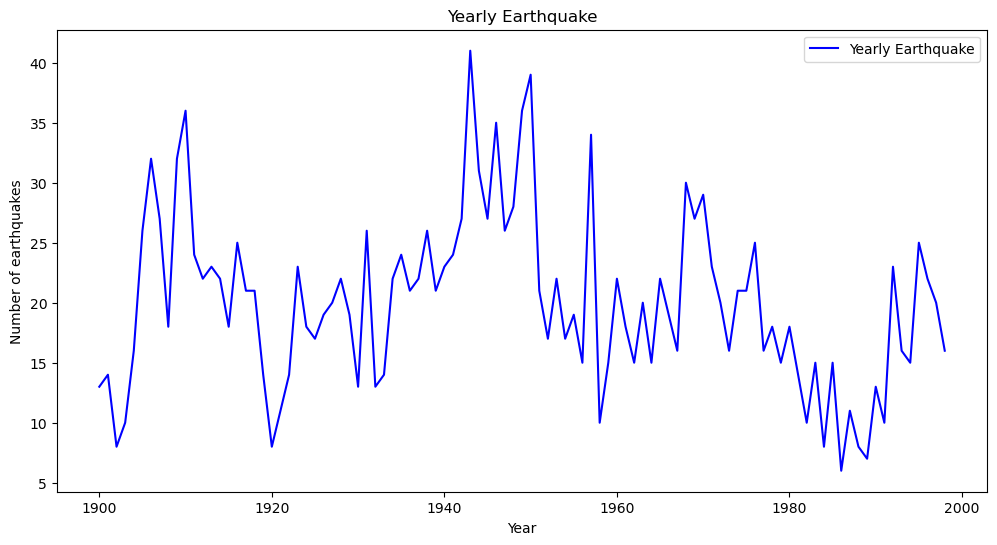

In [42]:
plt.figure(figsize=(12,6))
plt.plot(df, label="Yearly Earthquake", color='blue')
plt.title("Yearly Earthquake")
plt.xlabel("Year")
plt.ylabel("Number of earthquakes")
plt.legend()
plt.show()

## Check for Stationarity (Dickey-Fuller Test)

### ADF Test

In [43]:
# Perform Augmented Dickey-Fuller Test
result = adfuller(df['earthquakes_per_year'])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")  # If < 0.05, data is stationary

ADF Statistic: -3.183192251191782
p-value: 0.02097842525600371


📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.0002 ≤ 0.05)

# 🔹 Step 3: Train-Test Split

In [44]:

train_size = int(len(df) * 0.9)  # 90% training, 10% testing
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [45]:

print(f"Training Size: {len(train)} years")
print(f"Test Size: {len(test)} years")

Training Size: 89 years
Test Size: 10 years


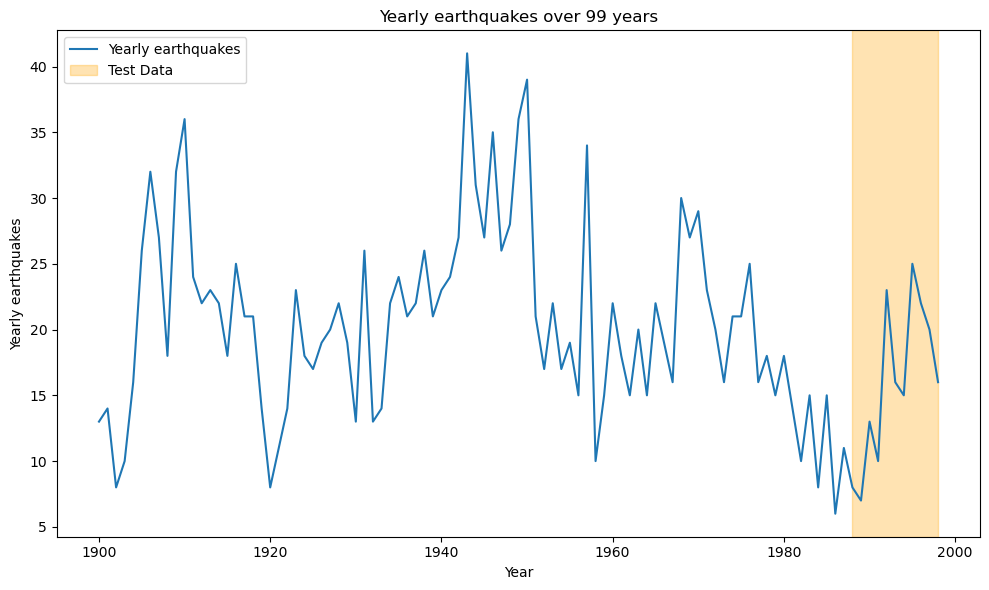

In [46]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['earthquakes_per_year'], label='Yearly earthquakes')

# Highlight the period corresponding to the test data
plt.axvspan(train.index[-1], df.index[-1], color='orange', alpha=0.3, label='Test Data')

# Add labels, title, and show legend
plt.xlabel('Year')
plt.ylabel('Yearly earthquakes')
plt.title('Yearly earthquakes over 99 years')
plt.legend()

plt.tight_layout()
plt.show()

# 🔹 Step 4: Create Baseline Models

## Historic Mean

In [47]:
historical_mean=np.mean(train['earthquakes_per_year'])

In [48]:
test = test.copy() 
test.loc[:, 'pred_mean'] = historical_mean
test

,earthquakes_per_year,pred_mean
date,,
1989-01-01,7.0,20.393258
1990-01-01,13.0,20.393258
1991-01-01,10.0,20.393258
1992-01-01,23.0,20.393258
1993-01-01,16.0,20.393258
1994-01-01,15.0,20.393258
1995-01-01,25.0,20.393258
1996-01-01,22.0,20.393258
1997-01-01,20.0,20.393258


## Create Last Known Value


In [49]:
last = train['earthquakes_per_year'].iloc[-1]
last

8.0

In [50]:
test.loc[:, 'pred_last'] = last
test

,earthquakes_per_year,pred_mean,pred_last
date,,,
1989-01-01,7.0,20.393258,8.0
1990-01-01,13.0,20.393258,8.0
1991-01-01,10.0,20.393258,8.0
1992-01-01,23.0,20.393258,8.0
1993-01-01,16.0,20.393258,8.0
1994-01-01,15.0,20.393258,8.0
1995-01-01,25.0,20.393258,8.0
1996-01-01,22.0,20.393258,8.0
1997-01-01,20.0,20.393258,8.0


## Evaluate Baseline Models

In [51]:
# Calculate MAE for pred_mean
mae_mean = mean_absolute_error(test["earthquakes_per_year"], test["pred_mean"])

# Calculate MAE for pred_last
mae_last = mean_absolute_error(test["earthquakes_per_year"], test["pred_last"])

# Print results
print(f"MAE for pred_mean: {mae_mean:.3f}")
print(f"MAE for pred_last: {mae_last:.3f}")

MAE for pred_mean: 5.457
MAE for pred_last: 8.900


# 🔹 Step 5: Create AR Model

## Determine Lag Order (p)

## ACF and PACF Plots


In [52]:
# ACF and PACF function to plot both Autocorrelation and Partial Autocorrelation
def ACF_and_PACF(data):
    # Create a figure with a specific size (12x9 inches)
    fig = plt.figure(figsize=(12,9))

    # Add subplot for ACF (Autocorrelation Function)
    ax1 = fig.add_subplot(211)  # The '211' means 2 rows, 1 column, and 1st subplot.
    fig = plot_acf(data, lags=40, ax=ax1)  # Plot the ACF with 40 lags (number of time lags to display).

    # Add subplot for PACF (Partial Autocorrelation Function)
    ax2 = fig.add_subplot(212)  # The '212' means 2 rows, 1 column, and 2nd subplot.
    fig = plot_pacf(data, lags=30, ax=ax2)  # Plot the PACF with 40 lags (number of time lags to display).



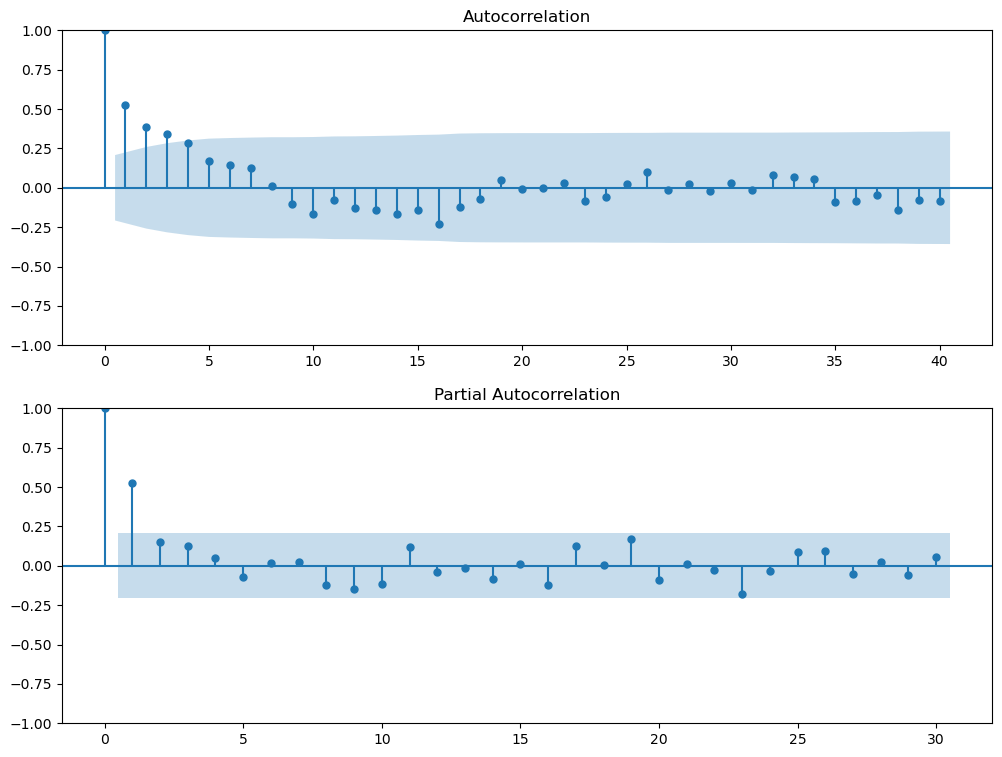

In [53]:
# Call the ACF_and_PACF function for the transformed train data
ACF_and_PACF(train['earthquakes_per_year'])

# 🔹 Step 6: Train AR Model - Fitting The Model

In [54]:
# df.index = pd.date_range(start=df.index[0], periods=len(df), freq="YS")  # "YS" means Year Start


In [55]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Fit AR model
p = 1
model_fit = ARIMA(train['earthquakes_per_year'], order=(1,0,0)).fit()





In [56]:
# Print model summary
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   89
Model:                   ARIMA(1, 0, 0)   Log Likelihood                -288.102
Date:                  Mon, 24 Feb 2025   AIC                            582.204
Time:                          09:42:46   BIC                            589.670
Sample:                      01-01-1900   HQIC                           585.213
                           - 01-01-1988                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1338      1.538     13.092      0.000      17.120      23.148
ar.L1          0.5452      0.086      6.350      0.000       0.377       0.713
sigma2        37.8018      5.190    

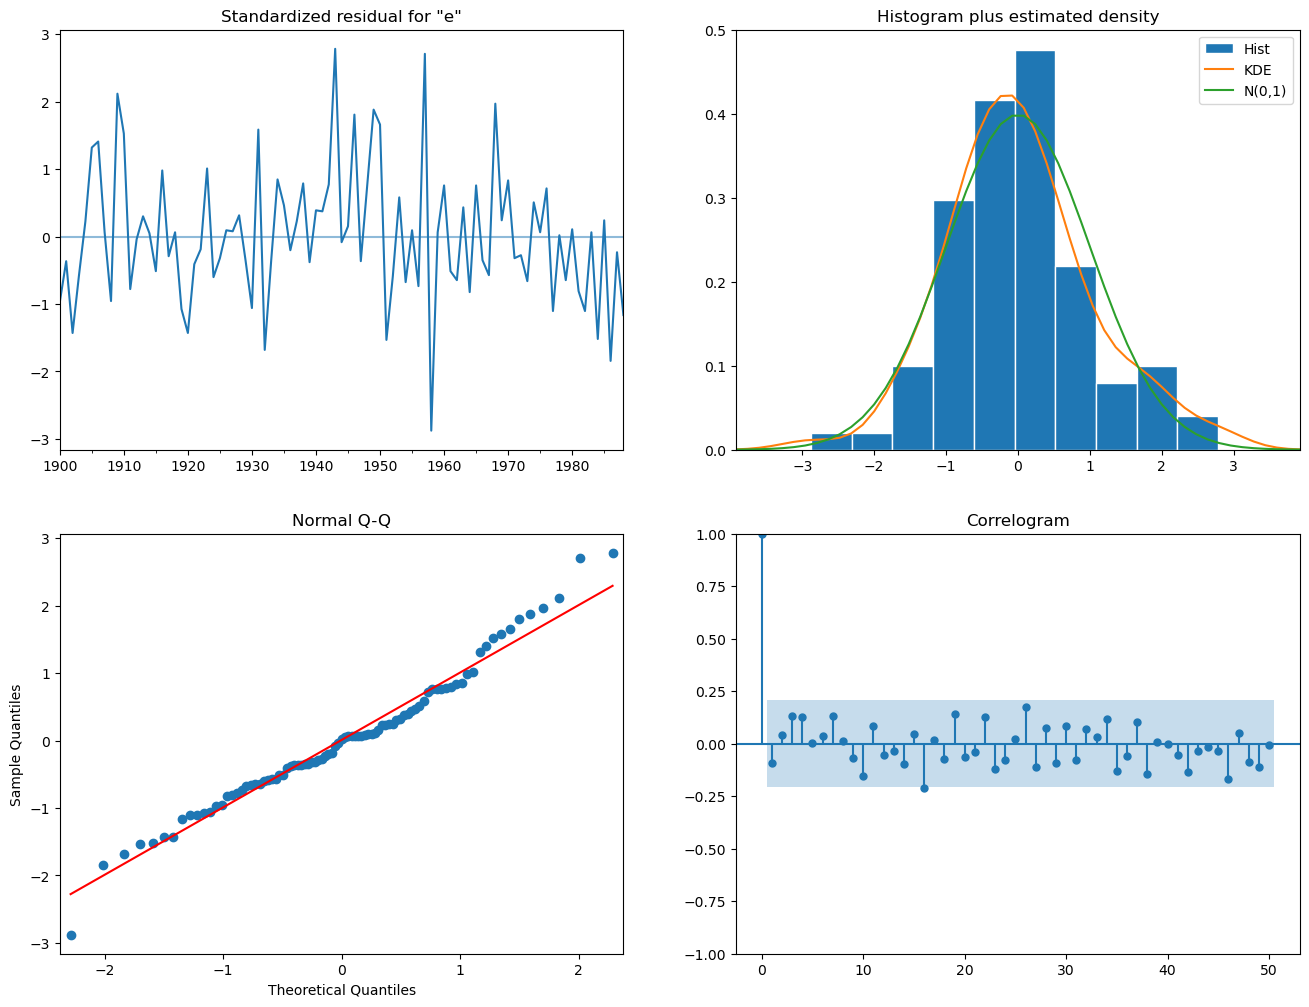

In [57]:
model_fit.plot_diagnostics(lags=50, figsize=(16,12))
plt.show()

# 🔹 Step 7: Model Evaluation - Forecasting on  Test Data
.

## 🔹 Evaluate Model on Test Data

In [68]:
test['earthquakes_per_year']

date
1989-01-01     7.0
1990-01-01    13.0
1991-01-01    10.0
1992-01-01    23.0
1993-01-01    16.0
1994-01-01    15.0
1995-01-01    25.0
1996-01-01    22.0
1997-01-01    20.0
1998-01-01    16.0
Name: earthquakes_per_year, dtype: float64

In [59]:
# forecast = model_fit.get_prediction(start=len(train), end=len(train)+len(test)-1,dynamic=False)


In [60]:
forecast_os = model_fit.get_prediction(start=pd.to_datetime('1989-01-01'),end=pd.to_datetime('1998-01-01'),dynamic=False)


In [61]:
#forecast mean
forecast_mean_os=forecast_os.predicted_mean.to_frame()
forecast_mean_os

,predicted_mean
1989-01-01,13.518250
1990-01-01,16.526882
1991-01-01,18.167233
1992-01-01,19.061577
1993-01-01,19.549187
1994-01-01,19.815039
1995-01-01,19.959985
1996-01-01,20.039012
1997-01-01,20.082099
1998-01-01,20.105590


In [62]:
confidence_intervals_os=forecast_os.conf_int()
confidence_intervals_os

,lower earthquakes_per_year,upper earthquakes_per_year
1989-01-01,1.467775,25.568725
1990-01-01,2.801718,30.252047
1991-01-01,3.982323,32.352144
1992-01-01,4.742849,33.380306
1993-01-01,5.190920,33.907453
1994-01-01,5.445040,34.185037
1995-01-01,5.586501,34.333469
1996-01-01,5.664492,34.413532
1997-01-01,5.707271,34.456927
1998-01-01,5.730671,34.480510


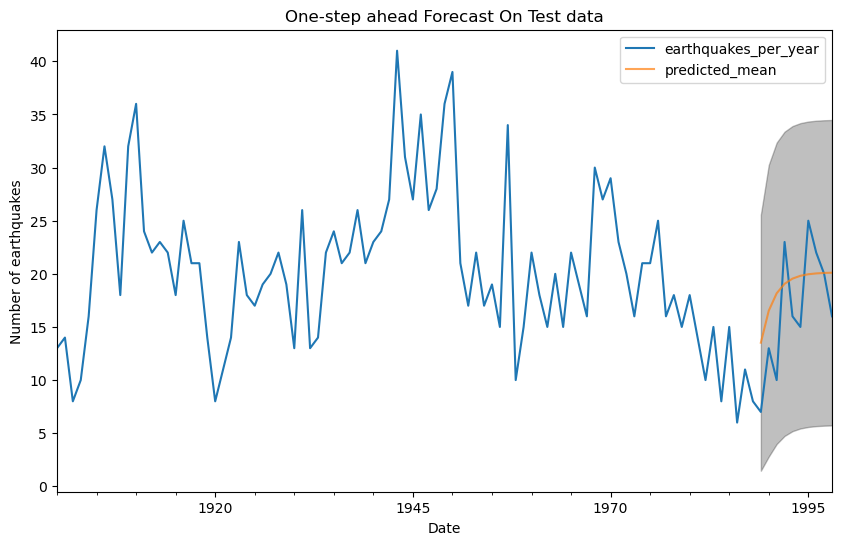

In [63]:
plt.close()
axis = df['1900-01-01':].plot(figsize=(10, 6))
forecast_mean_os.plot(ax=axis, label='One-step ahead Forecast', alpha=0.7)
axis.fill_between(confidence_intervals_os.index, confidence_intervals_os.iloc[:, 0], confidence_intervals_os.iloc[:, 1], color='k', alpha=.25)
axis.set_xlabel('Date')
axis.set_ylabel('Number of earthquakes')
plt.legend(loc='best')
plt.title('One-step ahead Forecast On Test data')
plt.show()

In [ ]:
# Forecast method

In [69]:
# Number of test points + desired future steps
total_steps = 10

# Get forecast
pred_uc = model_fit.forecast(steps=total_steps)



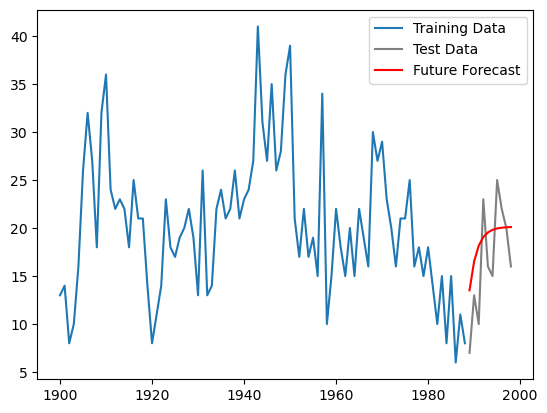

In [70]:
# Plot actual data
plt.plot(train.index, train['earthquakes_per_year'], label='Training Data')
plt.plot(test.index, test['earthquakes_per_year'], label='Test Data', color='gray')

# Plot future forecast
plt.plot(pred_uc.index, pred_uc, label='Future Forecast', color='red')


plt.legend()
plt.show()

In [71]:
# Calculate test error
mae_os_test = mean_absolute_error(test['earthquakes_per_year'], forecast_mean_os)
print(f"Test Data (Dynamic) MAE: {mae_os_test:.3f}")

Test Data (Dynamic) MAE: 4.170


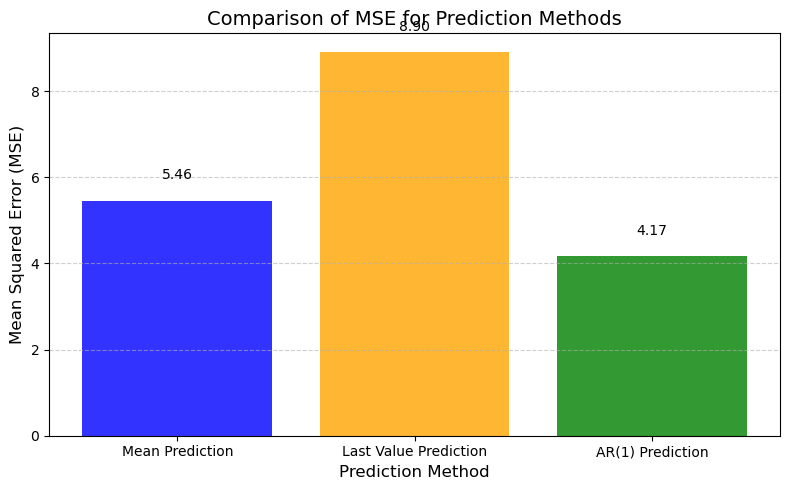

In [72]:
# MAE values

# Store in a list
mae_values = [mae_mean, mae_last, mae_os_test]

methods = ['Mean Prediction', 'Last Value Prediction', 'AR(1) Prediction']

# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(methods, mae_values, color=['blue', 'orange', 'green'], alpha=0.8)

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', ha='center', fontsize=10)

# Set labels and title
ax.set_xlabel('Prediction Method', fontsize=12)
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax.set_title('Comparison of MSE for Prediction Methods', fontsize=14)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()